In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# імпорт даних
weather_data1 = pd.read_csv('data_lviv.csv')

print(weather_data.shape)

(1395, 1)


In [67]:
weather_data.head(10)

,datatime,T_mu
0,2020-04-01,-0.15
1,2020-04-02,3.04
2,2020-04-03,6.55
3,2020-04-04,5.85
4,2020-04-05,6.14
5,2020-04-06,10.22
6,2020-04-07,9.74
7,2020-04-08,10.54
8,2020-04-09,11.89
9,2020-04-10,9.94


In [85]:
weather_data.set_index("datatime", inplace=True)

In [4]:
weather_data.describe()

,T_mu
count,1395.000000
mean,9.618495
std,8.171860
min,-15.070000
25%,2.890000
50%,9.680000
75%,16.645000
max,27.610000


In [5]:
print(weather_data.loc[weather_data["T_mu"] == weather_data["T_mu"].max()])
print(weather_data.loc[weather_data["T_mu"] == weather_data["T_mu"].min()])


             T_mu
datatime         
01.07.2022  27.61
             T_mu
datatime         
09.01.2024 -15.07


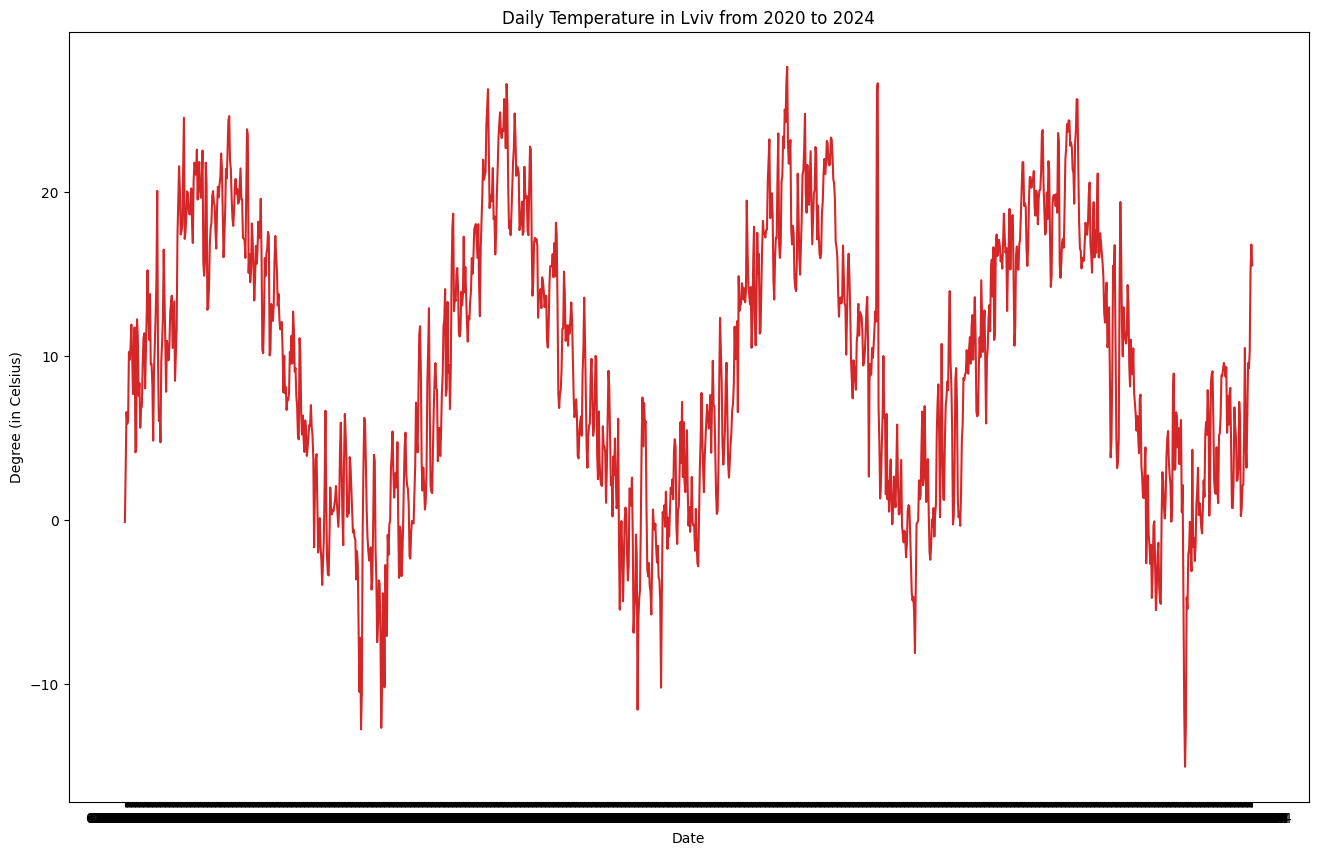

In [6]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(weather_data.index, weather_data.T_mu, color='tab:red')
plt.gca().set(title="Daily Temperature in Lviv from 2020 to 2024", xlabel='Date', ylabel="Degree (in Celsius)")
plt.show()

<Axes: xlabel='datatime'>

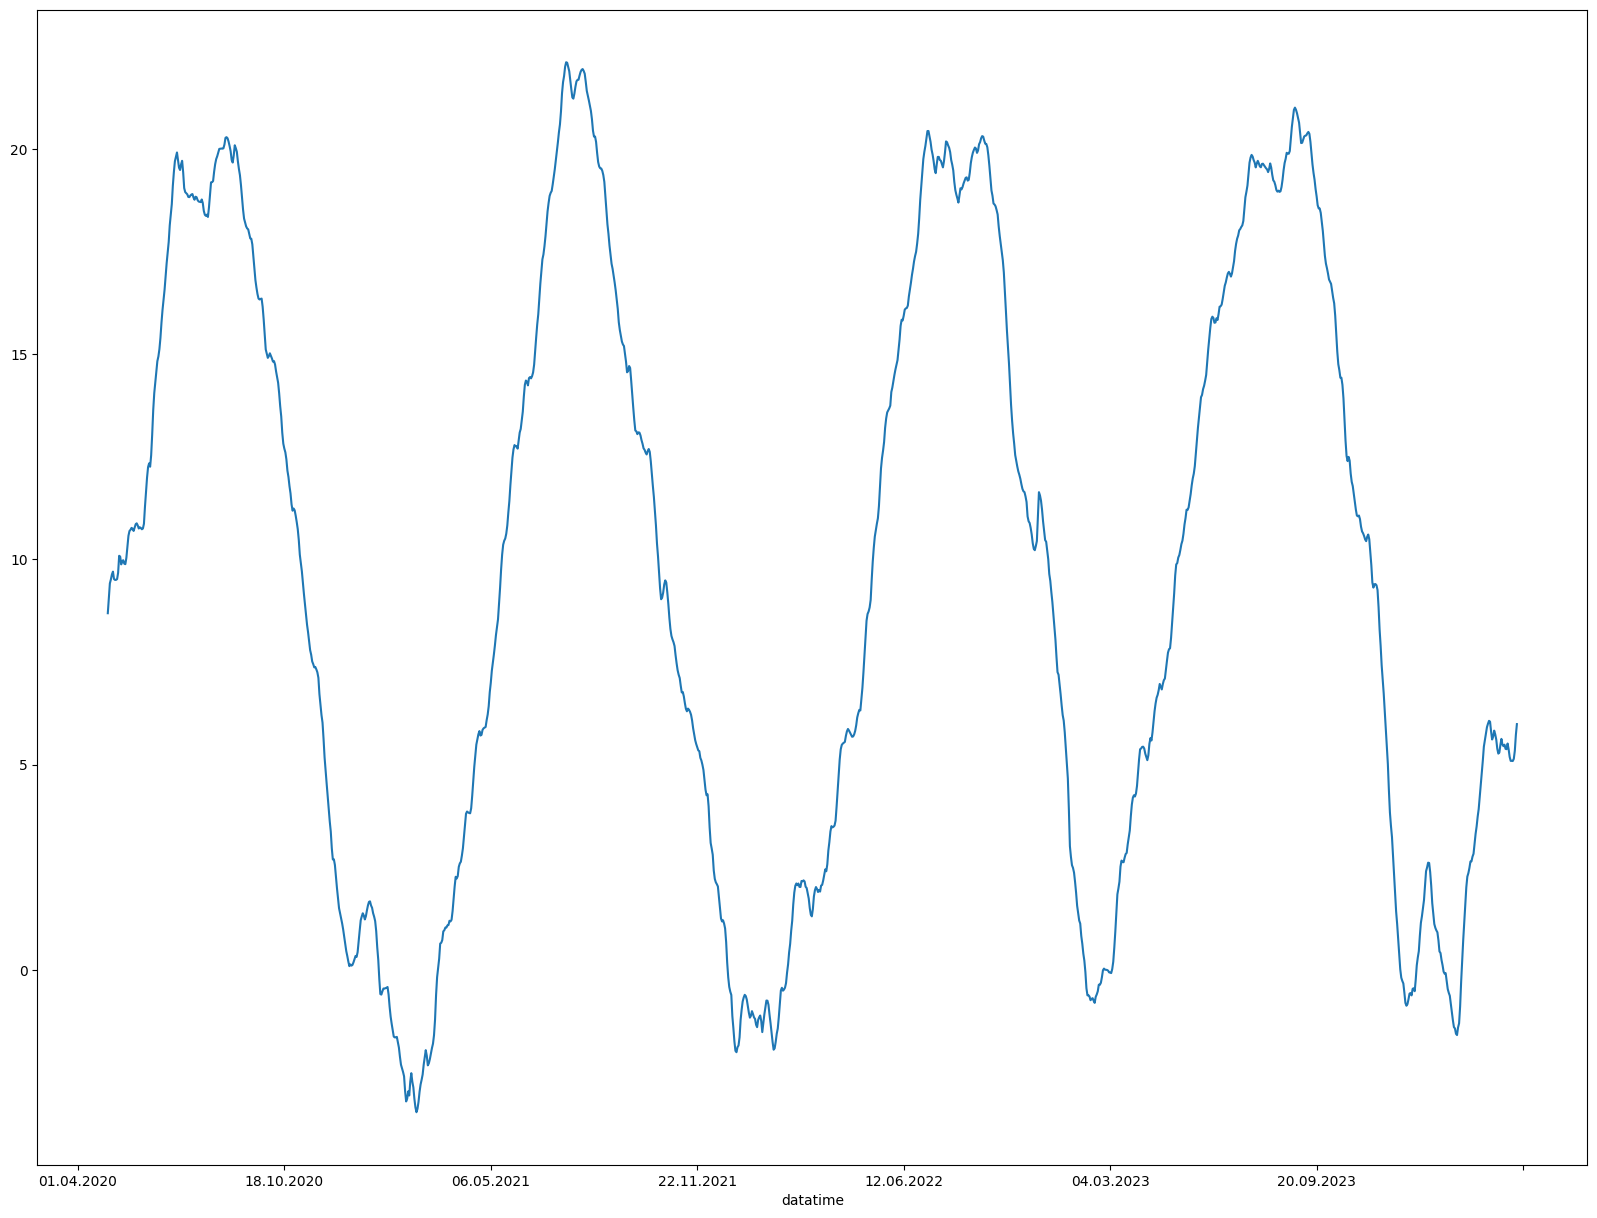

In [7]:
weather_data = weather_data.T_mu.rolling(window=30).mean()
weather_data.plot(figsize=(20,15))

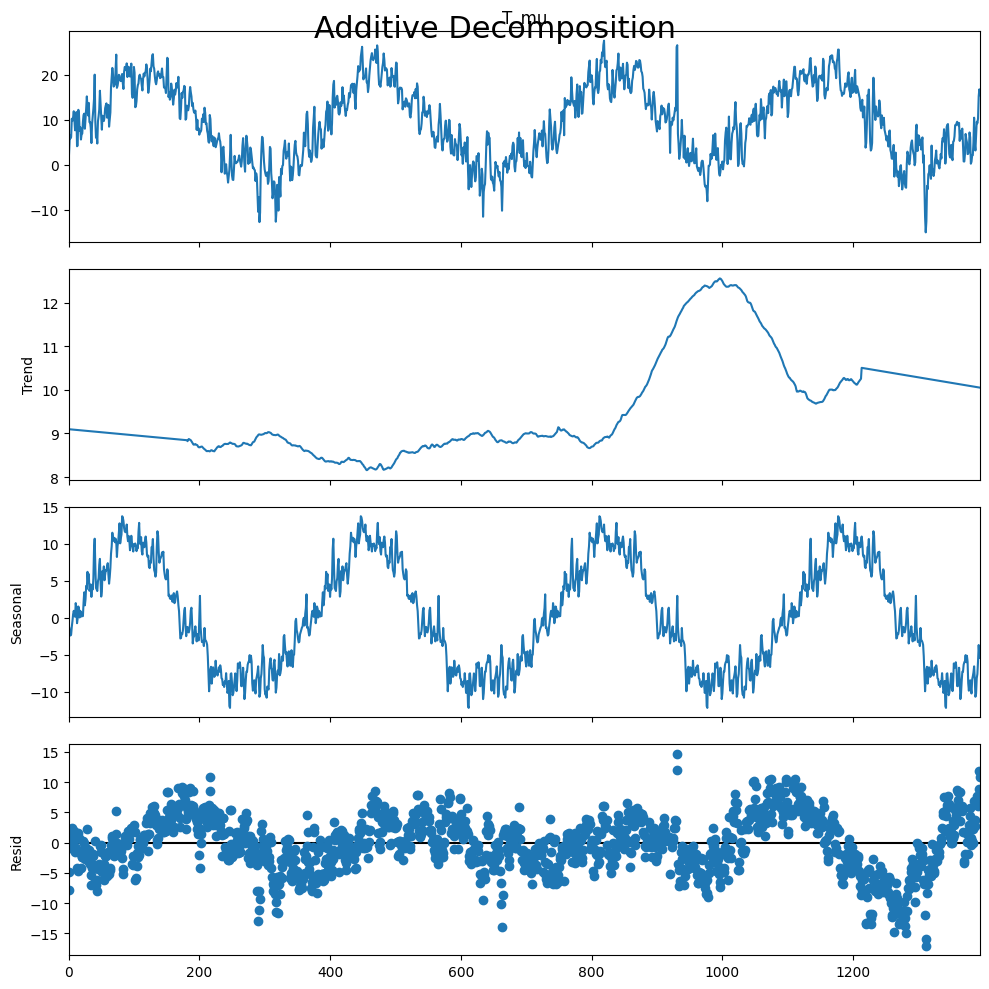

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(weather_data.T_mu, model='additive', extrapolate_trend='freq', period=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [12]:
weather_data.head(10)

,datatime,T_mu
0,01.04.2020,-0.15
1,02.04.2020,3.04
2,03.04.2020,6.55
3,04.04.2020,5.85
4,05.04.2020,6.14
5,06.04.2020,10.22
6,07.04.2020,9.74
7,08.04.2020,10.54
8,09.04.2020,11.89
9,10.04.2020,9.94


In [120]:
# Перенесли поточну температуру на наступний день.
predicted_df = weather_data["T_mu"].to_frame().shift(1).rename(columns = {"T_mu": "T_mu_pred" })
actual_df = weather_data["T_mu"].to_frame().rename(columns = {"T_mu": "T_mu_actual" })

# Об'єднюємо фактичну та прогнозовану температуру
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

one_step_df = one_step_df[1:]
one_step_df.head(10)

,T_mu_actual,T_mu_pred
datatime,,
2020-04-02,3.04,-0.15
2020-04-03,6.55,3.04
2020-04-04,5.85,6.55
2020-04-05,6.14,5.85
2020-04-06,10.22,6.14
2020-04-07,9.74,10.22
2020-04-08,10.54,9.74
2020-04-09,11.89,10.54
2020-04-10,9.94,11.89


In [105]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# розрахунок RMSE
temp_pred_err = MSE(one_step_df.T_mu_actual, one_step_df.T_mu_pred, squared=False)
print("RMSE буде",temp_pred_err)

RMSE буде 2.570300924719807


In [106]:
import itertools

# Визначаємо параметри p, d і q для отримання будь-якого значення від 0 до 2
p = d = q = range(0, 2)


# Згенеровуємо всі різні комбінації триплетів p, q і q
pdq = list(itertools.product(p, d, q))


seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Приклади комбінацій параметрів для  Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Приклади комбінацій параметрів для  Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [125]:
import statsmodels.api as sm

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11020.247877408287
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:9868.637806542378
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:8421.545120000139
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:8209.66945279486
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:8372.191015643377
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:8251.32162293225
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:8202.206514284546
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:8196.099195707608
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:9380.675016177887
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:8453.010036172054
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:7499.540884960534
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:7225.241037480972
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:7427.686909439082
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:7258.269174288423
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:7246.5852090609715
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:7219.443908408113
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6579.078963579274
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:6517.53420

In [147]:
import statsmodels.api as sm

# Встановлення моделі SARIMAX за оптимальними параметрами
mod = sm.tsa.statespace.SARIMAX(one_step_df.T_mu_actual,
                                order=(1, 1, 1),
                                seasonal_order=(0, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

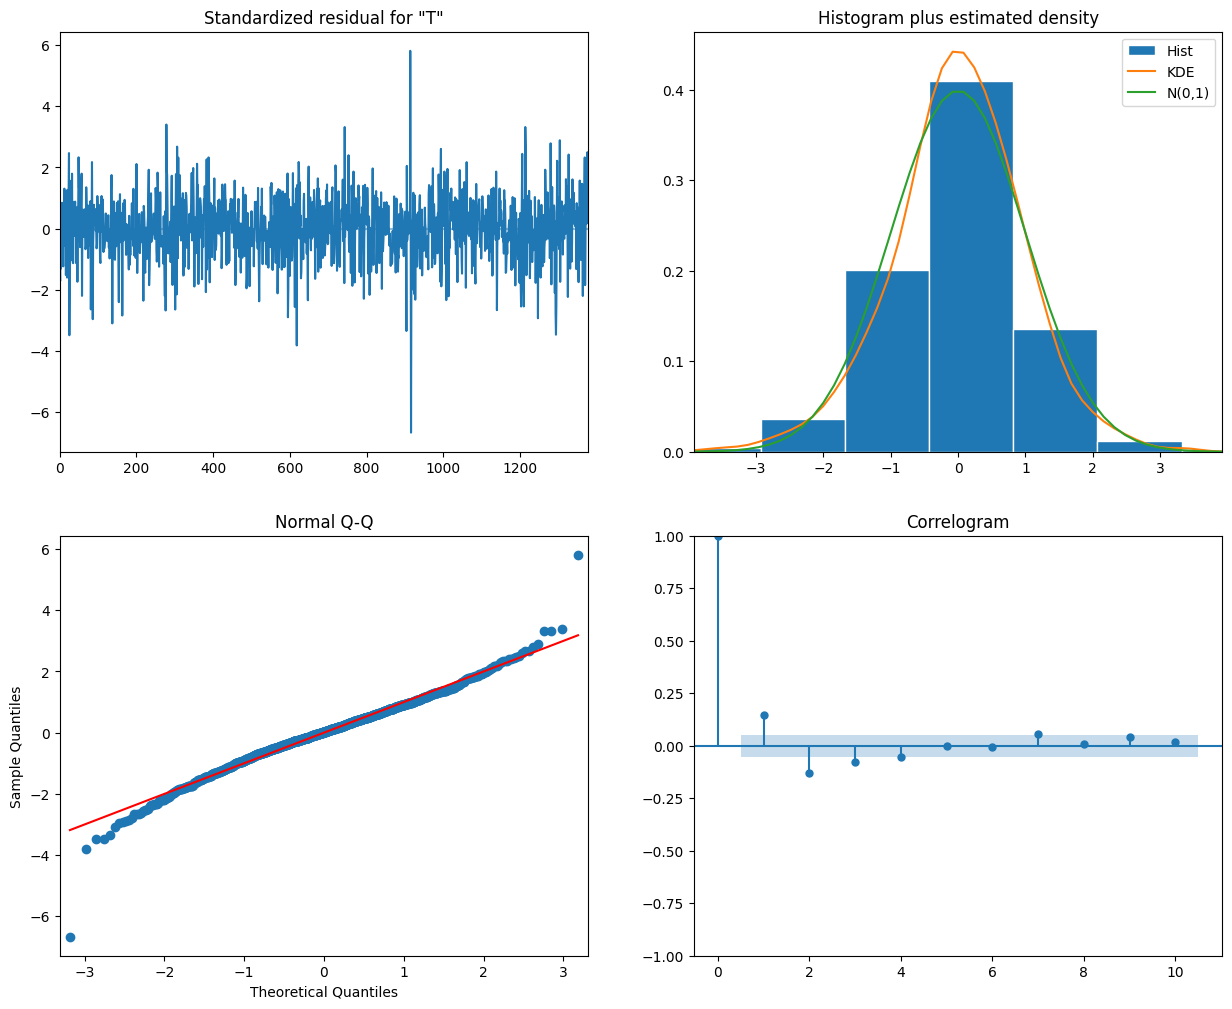

In [127]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [123]:
print(one_step_df)

        datatime  T_mu_actual  T_mu_pred
0     2020-04-02         3.04      -0.15
1     2020-04-03         6.55       3.04
2     2020-04-04         5.85       6.55
3     2020-04-05         6.14       5.85
4     2020-04-06        10.22       6.14
...          ...          ...        ...
1389  2024-03-28         9.21       9.55
1390  2024-03-29        10.29       9.21
1391  2024-03-30        15.22      10.29
1392  2024-03-31        16.77      15.22
1393  2024-04-01        15.50      16.77

[1394 rows x 3 columns]


In [48]:
weather_data.set_index("datatime", inplace=True)

In [111]:
print(results)

In [152]:
pred = results.get_prediction(start=pd.to_datetime('2022-03-01'), dynamic=False)
pred_ci = pred.conf_int()

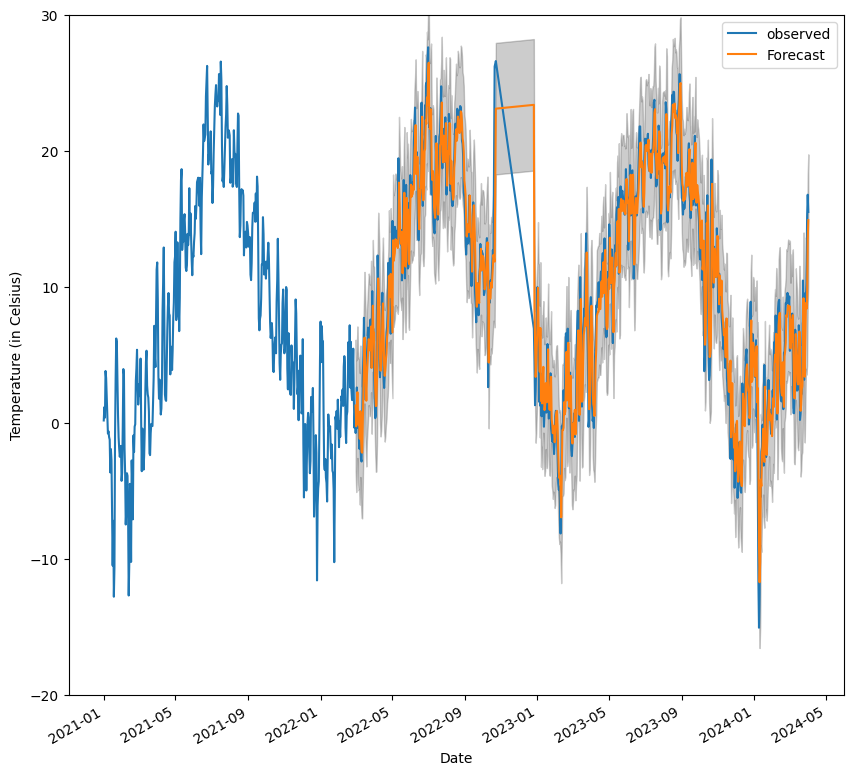

In [153]:
ax = one_step_df.T_mu_actual['2021':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [171]:
y_forecasted = pred.predicted_mean
y_truth = one_step_df.T_mu_actual['2022-03-01':]
print(y_forecasted.shape)
print(y_truth.shape)

mse = MSE(y_truth, y_forecasted, squared=True)
print('Середня квадратична помилка наших прогнозів становить {}'.format(round(mse, 2)))

(696,)
(696,)
Середня квадратична помилка наших прогнозів становить 6.48


In [163]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2022-10-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

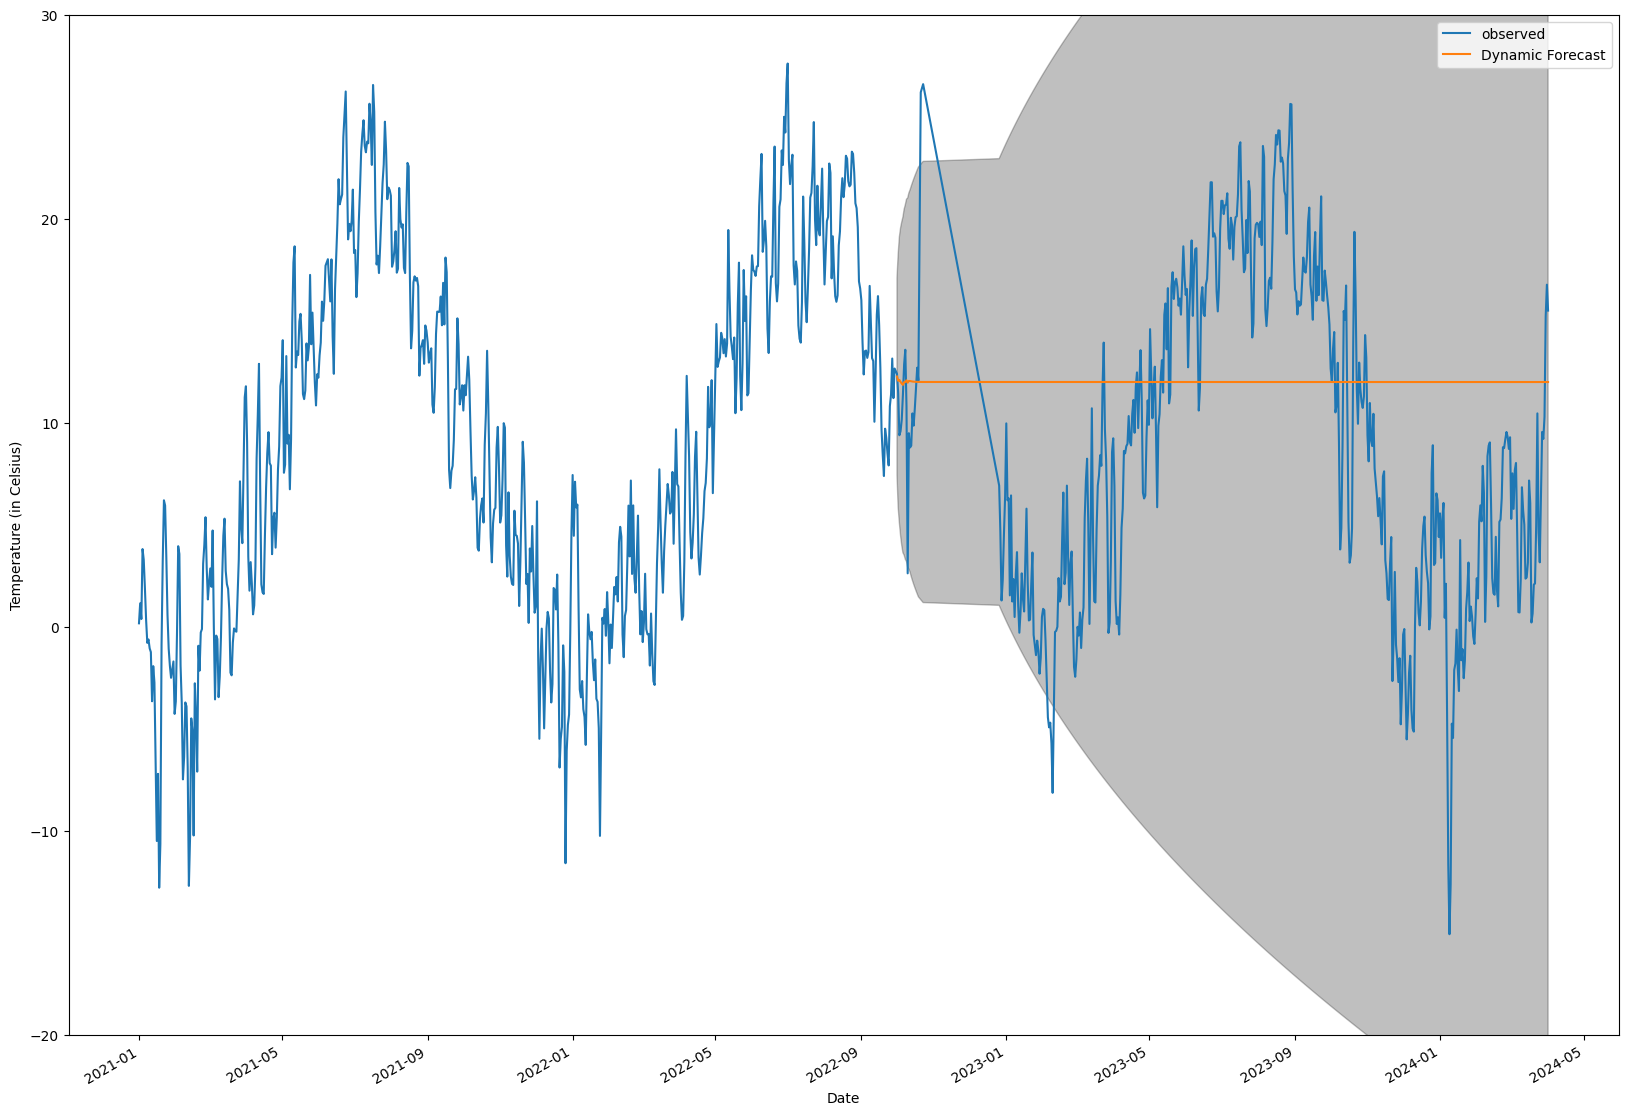

In [172]:
ax = one_step_df.T_mu_actual['2021':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([-20,30])
plt.legend()
plt.show()

In [166]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.T_mu_actual['2022-10-01':]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('Середньоквадратична помилка наших прогнозів становить {}'.format(round(mse, 2)))

Середньоквадратична помилка наших прогнозів становить 8.53


In [170]:
pred_dynamic_ci.head(10)

,lower T_mu_actual,upper T_mu_actual
datatime,,
2022-10-01,7.430811,17.103763
2022-10-02,5.842843,18.277684
2022-10-03,5.086680,19.114154
2022-10-04,4.467822,19.553894
2022-10-05,3.989994,19.846548
2022-10-06,3.630397,20.087974
2022-10-07,3.515219,20.468264
2022-10-08,3.306944,20.686798
2022-10-09,3.200827,20.961227
